## Forecasting one step ahead

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Load Data

In [2]:
df = pd.read_csv('../../Datasets/AirQualityUCI_ready.csv', 
parse_dates=['Date_Time'], 
index_col=['Date_Time'], usecols=['CO_sensor', 'RH', 'Date_Time'])

df = df.sort_index()

df = df.loc["2004-04-01":"2005-04-30"]

df = df.loc[(df["CO_sensor"] > 0)]

df.head()

,CO_sensor,RH
Date_Time,,
2004-04-04 00:00:00,1224.0,56.5
2004-04-04 01:00:00,1215.0,59.2
2004-04-04 02:00:00,1115.0,62.4
2004-04-04 03:00:00,1124.0,65.0
2004-04-04 04:00:00,1028.0,65.3


## Feature Engineering Pipeline with  feature engine

In [3]:
from sklearn.pipeline import Pipeline

from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from feature_engine.timeseries.forecasting import LagFeatures
from feature_engine.timeseries.forecasting import WindowFeatures
from feature_engine.selection import DropFeatures
from feature_engine.imputation import DropMissingData


date_feat = DatetimeFeatures(variables='index', 
            features_to_extract=['hour','month','week','weekend','day_of_week','day_of_month'])

cyclic_feat = CyclicalFeatures(variables=['hour','month'], drop_original=False)

lag_feat = LagFeatures(variables=['CO_sensor','RH'], freq=['1H','24H'], missing_values='ignore')

window_feat = WindowFeatures(variables=['CO_sensor', 'RH'], 
        freq='1H', window='3H',
        missing_values='ignore',
        functions=['mean'])

drop_missing = DropMissingData()

drop_feat = DropFeatures(features_to_drop=['CO_sensor', 'RH'])

In [4]:
pipe = Pipeline([ 
    ('datetime-features', date_feat),
    ('cyclic-features', cyclic_feat),
    ('lag', lag_feat),
    ('window', window_feat),
    ('drop-missing', drop_missing),
    ('avoid-lookahead-bias', drop_feat)
])


## Train Test Split


Due to our 24h lag feature, we need data about the pollutant information at least 24 hours before the first forecasting point in the test set to create input features.

Thus, the test set must contain the first forecasting point plus the previous 24 hours.




In [5]:
print(f'start : {df.index.min()},  end : {df.index.max()}')
print(f"last month start : {(df.index.max() - pd.Timedelta(value='31D'))}")

start : 2004-04-04 00:00:00,  end : 2005-04-04 14:00:00
last month start : 2005-03-04 14:00:00


#### The last month of data begins on `2005-03-4`.

#### But we need `24 hr` of prior data to create
#### the necessary lag features:


In [6]:
train_data = df.loc[df.index.min():(df.index.max() - pd.Timedelta(value='31D'))]
print(f'start : {train_data.index.min()},  end : {train_data.index.max()}')

start : 2004-04-04 00:00:00,  end : 2005-03-04 14:00:00


In [7]:
test_data = df.loc[(df.index.max() - pd.Timedelta(value='32D')):]
print(f'start : {test_data.index.min()},  end : {test_data.index.max()}')

start : 2005-03-03 14:00:00,  end : 2005-04-04 14:00:00


## Train & Test data Pipeline

In [8]:
X_train = pipe.fit_transform(train_data)

y_train = train_data['CO_sensor']

y_train = y_train.loc[X_train.index]

print('Shape of X_train :',X_train.shape,'\nShape of y_train :',y_train.shape)

Shape of X_train : (6442, 16) 
Shape of y_train : (6442,)


In [9]:
X_test = pipe.transform(test_data)

y_test = test_data['CO_sensor']

y_test = y_test.loc[X_test.index]

print('Shape of X_test :',X_test.shape,'\nShape of y_test :',y_test.shape)

Shape of X_test : (481, 16) 
Shape of y_test : (481,)


## Model

In [10]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error


lasso = Lasso().fit(X_train, y_train)
y_pred = lasso.predict(X_test)

print('MSE :',mean_squared_error(y_test, y_pred))
print('MAE :',mean_absolute_error(y_test, y_pred))

MSE : 9228.649750841569
MAE : 66.83326344904962


## Visuals

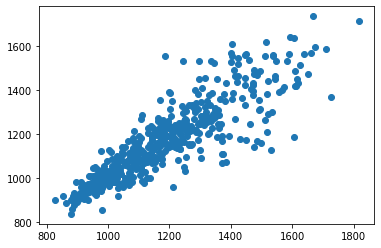

In [11]:
plt.scatter(y_test, y_pred);

## Bayesian Modeling

MSE : 9155.301913340058
MAE : 66.78137595598612


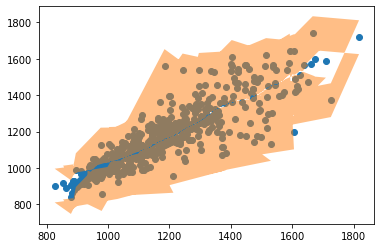

In [12]:
from sklearn.linear_model import BayesianRidge, ARDRegression


bays = BayesianRidge(compute_score=True, lambda_init=0.01)
bays.fit(X_train, y_train)

y_pred, y_std = bays.predict(X_test, return_std=True)

print('MSE :',mean_squared_error(y_test, y_pred))
print('MAE :',mean_absolute_error(y_test, y_pred))

plt.scatter(y_test, y_pred);
plt.fill_between(y_test, y_pred-y_std, y_pred+y_std, alpha=0.5);



## Bayesian ARD regression.


Fit the weights of a regression model, using an ARD prior. The weights of the regression model are assumed to be in Gaussian distributions. Also estimate the parameters lambda (precisions of the distributions of the weights) and alpha (precision of the distribution of the noise). 

MSE : 9170.028925178112
MAE : 66.86830420393434


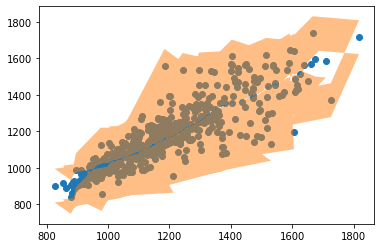

In [13]:
ard = ARDRegression(compute_score=True)
ard.fit(X_train, y_train)

y_pred = ard.predict(X_test)


print('MSE :',mean_squared_error(y_test, y_pred))
print('MAE :',mean_absolute_error(y_test, y_pred))

plt.scatter(y_test, y_pred);
plt.fill_between(y_test, y_pred-y_std, y_pred+y_std, alpha=0.5);